### API REST

#### 1. Tweepy

Empezamos con el código.

Verás que hay dos métodos de la clase Client:

● search_all_tweets: de todo el histórico.

● search_recent_tweets: últimos 7 días.

https://developer.twitter.com/en/docs/twitter-api/tweets/search/api-reference/get-tweets-search-recent

In [3]:
import tweepy
import numpy as np
import pandas as pd

# Replace these values with your actual keys and tokens
# api_key = 'DcX1p65pJqWVClE3e5c943Oe6'
# api_secret_key = 'Sh3cS2Z9HcQPCPNKaW0ROIE6wweKf9IjmK0T7v50R5EhJyQrat'
# access_token = '1505633898486800384-CIX78cr9Uva0VyTJkzl4kDWZtvoqXc'
# access_token_secret = 'onuAf8JeAUVab4nWB7GWB8wev1KiS2tUHPZ4ZwB3dDWBN'
auth = tweepy.OAuth2BearerHandler('AAAAAAAAAAAAAAAAAAAAAF6KpgEAAAAAVBs3jE3dGvngx7peoSyxteRTIBk%3DEArDRDzCFf0eEJUY0DR9lFhR0NWB4ffRoMxpzxvbEeLu4gwkf2')

# Authenticate with Twitter API
try:
    cliente = tweepy.Client(auth, wait_on_rate_limit = True)
    # Authenticate with Twitter API
    #auth = tweepy.OAuthHandler(api_key, api_secret_key)
    #auth.set_access_token(access_token, access_token_secret)
    cliente = tweepy.Client(auth)

    # Retrieve the authenticated user's profile

    print(f"Authentication OK.")

except tweepy.errors.Forbidden as e:
    # Handle authentication errors
    print("Error during authentication:", e)

#Parámetros de la consulta
consulta = input("Introduce la palabra clave: ")
numTweet = int(input ("¿Cuántos tweets quieres recuperar?: "))

#Realizamos la consulta
tweets = cliente.search_recent_tweets(
query=consulta,
max_results=numTweet,
expansions='author_id',
)

#Vamos preparando la salida

df = pd.DataFrame(tweets.data)
df.head()



Authentication OK.


Introduce la palabra clave:  diabetes
¿Cuántos tweets quieres recuperar?:  10


Unauthorized: 401 Unauthorized
Unauthorized

El error que se obtiene no es debido al código sino a que recientemente Twitter ha cambiado las condiciones del plan Free de desarrolladores en el momento que se probó:
_______________________________________________________________________________________________________________________
Your app has the Free access tier which only allows:

    Posting tweets with the Twitter API v2
    Media Upload and Login With Twitter with the Twitter API v1.1

To do anything else, you need at least the Basic access tier, which costs some money.

The access tiers are documented in https://developer.twitter.com/en/docs/twitter-api/getting-started/about-twitter-api
_______________________________________________________________________________________________________________________

Antes el resultado era: 

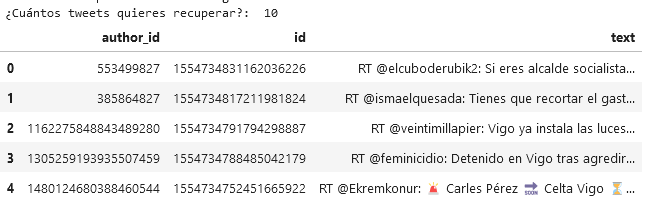

Si, por ejemplo, quisiésemos añadir el objeto users (usuarios) dentro de includes, añadiríamos las modificaciones siguientes.

In [4]:
usuarios = tweets.includes['users']

#Generamos un diccionario con id de autor y su username {autor_id: autor_usename}
#fijarse en la función LAMBDA usual en Python
usuarios = {usuario.id: usuario.username for usuario in usuarios}

# Construimos la lista con la que después generaremos el dataframe.
# Cada elemento de la lista es un diccionario con los 3 campos que queremos

lista_tweets = []

for tweet in tweets.data:
    lista_tweets.append({
        'id': tweet.id,
        'username': usuarios[tweet.author_id],
        'texto': tweet.text
})

NameError: name 'tweets' is not defined

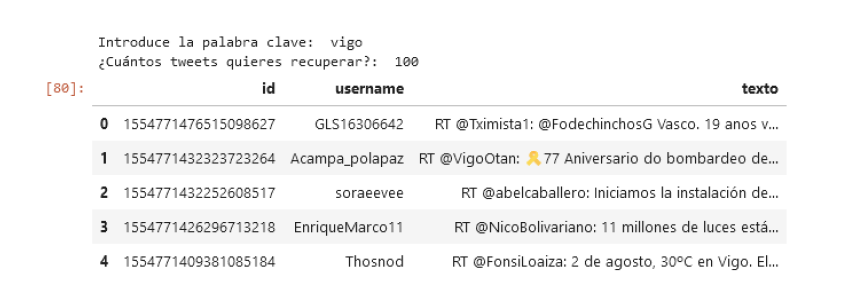

Si quisiésemos, en vez de los últimos días, establecer una escucha continua, analizando en cada momento la posibilidad de patrón de interés, Streaming, se disponde la clase tweepy.StreamingClient

In [40]:
import tweepy

# Autenticación
bearerToken = 'AAAAAAAAAAAAAAAAAAAAAF6KpgEAAAAAjQFfFHWsmzOLzAvZmW71fWDMSOU%3DnemLoAVrThuXupJV4nCUVKhYTI9F3OKHMNLTxHe0xepO9cRCKl'

# Parámetros de la consulta
consulta = input("Introduce la palabra clave: ")
#Hacemos un override de StreamingClient para añadir método

# a ejecutar cuando se genere un nuevo tweet. on_tweet cada vez que genera un tweet imprima su texto
class capturaMisTweets(tweepy.StreamingClient):
    def on_tweet(self, tweet):
        print(tweet.text)
        print("------------------")
        
    # Creamos la instancia de cliente con el token de acceso.
        cliente = capturaMisTweets(bearer_token=bearerToken)
    
    # Filtramos la consulta para que solo muestre lo que nos interesa, para pararlo botón stop
        cliente.add_rules(tweepy.StreamRule(consulta))
        cliente.filter()

Introduce la palabra clave:  ucrania


#### Utilizando la API Twitter

Partiremos de la siguiente petición con las modificaciones que se establecerán en el código:
    
    curl --request GET 'https://api.twitter.com/2/tweets/search/recent?query=from:twitterdev' --header 'Authorization: Bearer $BEARER_TOKEN'

In [27]:
import requests

# Autenticación
bearerToken = 'AAAAAAAAAAAAAAAAAAAAAF6KpgEAAAAAVBs3jE3dGvngx7peoSyxteRTIBk%3DEArDRDzCFf0eEJUY0DR9lFhR0NWB4ffRoMxpzxvbEeLu4gwkf2'

# Endpoint de acceso
url = 'https://api.twitter.com/2/tweets/search/recent'

# Datos a buscar
consulta = input("Introduce la palabra clave: ")
numTweet = input ("¿Cuántos tweets quieres recuperar?: ")

# Realizamos la consulta. Debemos mandar en la cabecera el token de acceso
response = requests.get(url + '?query=' + consulta + '&max_results=' + numTweet + '&tweet.fields=source', headers = { "Authorization": "Bearer " + bearerToken }
    )
print(response.text) #explicación del error
tweets = response.json()

# Mostramos el texto de los tweets obtenidos

for tweet in tweets['data']:
    print(tweet['source'], ":", tweet['text'])
    print("------------------")
        


Introduce la palabra clave:  amnistía
¿Cuántos tweets quieres recuperar?:  41


{"client_id":"27691614","detail":"When authenticating requests to the Twitter API v2 endpoints, you must use keys and tokens from a Twitter developer App that is attached to a Project. You can create a project via the developer portal.","registration_url":"https://developer.twitter.com/en/docs/projects/overview","title":"Client Forbidden","required_enrollment":"Appropriate Level of API Access","reason":"client-not-enrolled","type":"https://api.twitter.com/2/problems/client-forbidden"}


KeyError: 'data'

Aunque el código está correcto nos da el mensaje de que no tenemos el nivel de acceso a la API. Recordemos que estamos en el plan Free. 

**He aquí el negocio de Twitter, no solo la publicidad. Nosotros, al usarlo, introducimos una cantidad de datos enorme que almacenan en sus BBDD, y a través de las API nos cobran el acceso a la misma para poder extraer patrones.**

#### 2. Geolocalización

**Nominatim** tiene dos métodos básicos.

.**geocode**: devuelve datos a partir de la dirección

.**reverse**: devuelve datos a parir de coordenadas.

Empecemos con el código, previamente instalamos **geopy**.

In [9]:
from geopy.geocoders import Nominatim
import pandas as pd

# damos un nombre a la aplicación

geolocator = Nominatim(user_agent='BD_2324_Teis')
                       
# consulta de datos a partir de la dirección 
                       
direccion = input("Por favor indique una direccion: ")
                       
location = geolocator.geocode(direccion)
df = pd.DataFrame(location)

display(df)

print(location.raw)              #fichero json
print(location.latitude)
print(location.longitude)

# a partir de coordenadas

latitud = input("Por favor indique una latitud: ")

longitud = input("Por favor indique una longitud: ")

location = geolocator.reverse(latitud + ',' + longitud)

df = pd.DataFrame(location)

# Mostrar el DataFrame usando print
display(df)

Por favor indique una direccion:  Avenida de Galicia, 101 Vigo


,0
0,"Instituto de Educación Secundaria de Teis, 101..."
1,"(42.251561699999996, -8.690280966610313)"


{'place_id': 250683966, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright', 'osm_type': 'way', 'osm_id': 122500123, 'lat': '42.251561699999996', 'lon': '-8.690280966610313', 'class': 'amenity', 'type': 'school', 'place_rank': 30, 'importance': 9.99999999995449e-06, 'addresstype': 'amenity', 'name': 'Instituto de Educación Secundaria de Teis', 'display_name': 'Instituto de Educación Secundaria de Teis, 101, Avenida de Galicia, Nosa Señora das Neves, Teis, Vigo, Pontevedra, Galicia, 36216, España', 'boundingbox': ['42.2508433', '42.2522684', '-8.6909659', '-8.6895014']}
42.251561699999996
-8.690280966610313


Por favor indique una latitud:  -8.706967
Por favor indique una longitud:  42.251561699999996


""


#### 3. OMDB

Ya tenemos nuestra clave activada y empezamos con el código.
Vamos a obtener en un fichero .json una serie de datos de películas almacenadas en OMBD

In [1]:
import requests
import numpy as np
import pandas as pd
url='http://www.omdbapi.com/'
params = dict(
    Apikey = 'aac5f6f',
    t = 'Napoleon',
    type = 'movie'
)
resp = requests.get(url=url, params=params)
datos=resp.json()
print(datos['Title'])
df = pd.DataFrame(datos)
display(df)



# Realizar solicitud para obtener información sobre las películas
response = requests.get(url=url, params=params)

# Verificar el estado de la respuesta
if response.status_code == 200:
    # Convertir la respuesta a formato JSON
    data = response.json()
    print(data)

    # Verificar si la solicitud fue exitosa y si hay resultados
    if data.get('Response') == 'True':
        # Obtener la lista de películas
        peliculas = data.get('Search', [])

        if peliculas:
            # Ordenar las películas por IMDb rating de mayor a menor
            peliculas_ordenadas = sorted(peliculas, key=lambda x: float(x.get('imdbRating', 0)), reverse=True)

            # Imprimir las 10 películas con el mayor IMDb rating
            for pelicula in peliculas_ordenadas[:10]:
                print(f"{pelicula['Title']} - IMDb Rating: {pelicula.get('imdbRating', 'N/A')}")
        else:
            print("No se encontraron resultados.")
    else:
        print(f"Error: {data.get('Error', 'Respuesta incorrecta de la API')}")
else:
    print(f"Error en la solicitud. Código de estado: {response.status_code}")

Napoleon


,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
0,Napoleon,2023,R,22 Nov 2023,158 min,"Action, Adventure, Biography",Ridley Scott,David Scarpa,"Joaquin Phoenix, Vanessa Kirby, Tahar Rahim",An epic that details the checkered rise and fa...,...,N/A,6.6,"63,888",tt13287846,movie,N/A,"$55,440,044",N/A,N/A,True


{'Title': 'Napoleon', 'Year': '2023', 'Rated': 'R', 'Released': '22 Nov 2023', 'Runtime': '158 min', 'Genre': 'Action, Adventure, Biography', 'Director': 'Ridley Scott', 'Writer': 'David Scarpa', 'Actors': 'Joaquin Phoenix, Vanessa Kirby, Tahar Rahim', 'Plot': 'An epic that details the checkered rise and fall of French Emperor Napoleon Bonaparte and his relentless journey to power through the prism of his addictive, volatile relationship with his wife, Josephine.', 'Language': 'English', 'Country': 'United States, United Kingdom', 'Awards': '7 nominations', 'Poster': 'https://m.media-amazon.com/images/M/MV5BZWIzNDAxMTktMDMzZS00ZjJmLTlhNjYtOGUxYmZlYzVmOGE4XkEyXkFqcGdeQXVyODk4OTc3MTY@._V1_SX300.jpg', 'Ratings': [{'Source': 'Internet Movie Database', 'Value': '6.6/10'}], 'Metascore': 'N/A', 'imdbRating': '6.6', 'imdbVotes': '63,888', 'imdbID': 'tt13287846', 'Type': 'movie', 'DVD': 'N/A', 'BoxOffice': '$55,440,044', 'Production': 'N/A', 'Website': 'N/A', 'Response': 'True'}
No se encontrar

In [4]:
import requests

# Reemplaza 'TU_CLAVE_DE_API' con tu clave de API de OMDB
api_key = 'aac5f6f'

# URL base de la API de OMDB
base_url = 'http://www.omdbapi.com/'

tipo = input("Por favor si es una `series` o `movie`: ")
titulo = input("Por favor algún término del título: ")

# Parámetros de la primera solicitud para obtener una lista de películas
params_search = {'apikey': api_key, 'type': tipo, 's': titulo }

# Realizar la primera solicitud para obtener una lista de películas
response_search = requests.get(base_url, params=params_search)

# Verificar el estado de la respuesta
if response_search.status_code == 200:
    # Convertir la respuesta a formato JSON
    data_search = response_search.json()

    # Verificar si la solicitud fue exitosa y si hay resultados
    if data_search.get('Response') == 'True':
        # Obtener la lista de películas
        peliculas = data_search.get('Search', [])

        if peliculas:
            # Ordenar las películas por IMDb rating de mayor a menor
            peliculas_ordenadas = sorted(peliculas, key=lambda x: float(x.get('imdbRating', 0)), reverse=True)

            # Tomar las 20 primeras películas
            top_10_peliculas = peliculas_ordenadas[:20]

            # Realizar solicitudes adicionales para obtener información detallada por IMDb ID
            for pelicula in top_10_peliculas:
                imdb_id = pelicula.get('imdbID')
                
                # Parámetros de la segunda solicitud para obtener información detallada
                params_detail = {'apikey': api_key, 'i': imdb_id}

                # Realizar la segunda solicitud para obtener información detallada
                response_detail = requests.get(base_url, params=params_detail)
                data_detail = response_detail.json()

                # Imprimir información de cada película
                print(f"{data_detail.get('Title')} - IMDb Rating: {data_detail.get('imdbRating', 'N/A')}")

        else:
            print("No se encontraron resultados.")
    else:
        print(f"Error: {data_search.get('Error', 'Respuesta incorrecta de la API')}")
else:
    print(f"Error en la primera solicitud. Código de estado: {response_search.status_code}")


Por favor si es una `series` o `movie`:  movie
Por favor algún término del título:  war


Avengers: Infinity War - IMDb Rating: 8.4
Captain America: Civil War - IMDb Rating: 7.8
World War Z - IMDb Rating: 7.0
War of the Worlds - IMDb Rating: 6.5
Lord of War - IMDb Rating: 7.6
War for the Planet of the Apes - IMDb Rating: 7.4
War Dogs - IMDb Rating: 7.1
The Tomorrow War - IMDb Rating: 6.6
This Means War - IMDb Rating: 6.3
War Horse - IMDb Rating: 7.2
